## Setup
For this lab you need to install __gensim__ and __nltk__.

In [ ]:
!pip install gensim

In [ ]:
!pip install nltk

In [ ]:
import gensim.downloader as api

from tensorflow.keras.datasets import imdb
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
import pandas as pd
from sklearn.manifold import TSNE
from tensorflow.keras.layers import *
import tensorflow as tf

# 1. Introduction

In this homework, you will see the power of word embeddings, and how embeddings can be used to improve results of movie sentiment analysis from previous homeworks.

The data set can be found in `https://keras.io/api/datasets/imdb/`.

In [ ]:
NUM_WORDS=1000 # only use top 1000 words
INDEX_FROM=3   # word index offset
MAX_LEN=200    # maximum sentence length

(x_train, y_train), (x_test, y_test) = imdb.load_data(
    num_words=NUM_WORDS, index_from=INDEX_FROM, maxlen=MAX_LEN)
x_train.shape

17473536/17464789 [==============================] - 0s 0us/step


(14244,)

In [ ]:
word_index = imdb.get_word_index()
word_index = {k:(v+INDEX_FROM) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2
inverted_word_index = dict((i, word) for (word, i) in word_index.items())

1654784/1641221 [==============================] - 0s 0us/step


In [ ]:
np.array(x_train[0])

array([  1, 194,   2, 194,   2,  78, 228,   5,   6,   2,   2,   2, 134,
        26,   4, 715,   8, 118,   2,  14, 394,  20,  13, 119, 954, 189,
       102,   5, 207, 110,   2,  21,  14,  69, 188,   8,  30,  23,   7,
         4, 249, 126,  93,   4, 114,   9,   2,   2,   5, 647,   4, 116,
         9,  35,   2,   4, 229,   9, 340,   2,   4, 118,   9,   4, 130,
         2,  19,   4,   2,   5,  89,  29, 952,  46,  37,   4, 455,   9,
        45,  43,  38,   2,   2, 398,   4,   2,  26,   2,   5, 163,  11,
         2,   2,   4,   2,   9, 194, 775,   7,   2,   2, 349,   2, 148,
       605,   2,   2,  15, 123, 125,  68,   2,   2,  15, 349, 165,   2,
        98,   5,   4, 228,   9,  43,   2,   2,  15, 299, 120,   5, 120,
       174,  11, 220, 175, 136,  50,   9,   2, 228,   2,   5,   2, 656,
       245,   2,   5,   4,   2, 131, 152, 491,  18,   2,  32,   2,   2,
        14,   9,   6, 371,  78,  22, 625,  64,   2,   9,   8, 168, 145,
        23,   4,   2,  15,  16,   4,   2,   5,  28,   6,  52, 15

# 2. GloVe

We will first read imdb movie reviews to train a GloVe embeddings.

GloVe is computed from a co-occurrence matrix $X$ as follows:

$$
J = \sum_{i=1,j=1}^{V,V} f(X_{ij}) (w_i^T w_j + b_i + b_j - log(X_{ij}))^2
$$

$f(X_{ij}) = (X_{ij} / X_{\max})^\alpha$ if $X_{ij} < X_{\max}$; otherwise it is $1$.

$$
\nabla_{w_i} J = f(X_{ij}) w_j (w_i^T w_j + b_i + b_j - log(X_{ij}))
$$

$$
\nabla_{w_j} J = f(X_{ij}) w_i (w_i^T w_j + b_i + b_j - log(X_{ij}))
$$

$$
\nabla_{b_i} J = \nabla_{b_j} J = f(X_{ij}) (w_i^T w_j + b_i + b_j - log(X_{ij}))
$$

In [ ]:
word_counts = NUM_WORDS

In [ ]:
V = NUM_WORDS
V

1000

In [ ]:
print(len(x_train))
print()
print([len(s) for s in x_train[0:100]])

S = 2000

if S < len(x_train):
    x_train = x_train[:S]

14244

[189, 141, 147, 43, 123, 130, 99, 117, 109, 129, 163, 177, 129, 140, 93, 142, 193, 171, 174, 162, 51, 139, 142, 132, 122, 55, 103, 186, 113, 169, 138, 146, 59, 107, 152, 186, 147, 118, 132, 167, 115, 95, 158, 156, 82, 190, 174, 60, 145, 170, 107, 171, 158, 145, 67, 123, 195, 91, 183, 50, 118, 147, 141, 60, 56, 144, 129, 153, 55, 92, 174, 187, 183, 165, 78, 198, 156, 127, 61, 84, 57, 176, 159, 57, 159, 165, 194, 149, 130, 19, 98, 130, 153, 143, 136, 125, 142, 148, 198, 193]


Let's now get the dictionary of words to indexes and indexes to words.

In [ ]:
# Decode the first sequence in the dataset
decoded_sequence = " ".join(inverted_word_index[i] for i in x_train[0])
print(x_train[0])
decoded_sequence

[1, 194, 2, 194, 2, 78, 228, 5, 6, 2, 2, 2, 134, 26, 4, 715, 8, 118, 2, 14, 394, 20, 13, 119, 954, 189, 102, 5, 207, 110, 2, 21, 14, 69, 188, 8, 30, 23, 7, 4, 249, 126, 93, 4, 114, 9, 2, 2, 5, 647, 4, 116, 9, 35, 2, 4, 229, 9, 340, 2, 4, 118, 9, 4, 130, 2, 19, 4, 2, 5, 89, 29, 952, 46, 37, 4, 455, 9, 45, 43, 38, 2, 2, 398, 4, 2, 26, 2, 5, 163, 11, 2, 2, 4, 2, 9, 194, 775, 7, 2, 2, 349, 2, 148, 605, 2, 2, 15, 123, 125, 68, 2, 2, 15, 349, 165, 2, 98, 5, 4, 228, 9, 43, 2, 2, 15, 299, 120, 5, 120, 174, 11, 220, 175, 136, 50, 9, 2, 228, 2, 5, 2, 656, 245, 2, 5, 4, 2, 131, 152, 491, 18, 2, 32, 2, 2, 14, 9, 6, 371, 78, 22, 625, 64, 2, 9, 8, 168, 145, 23, 4, 2, 15, 16, 4, 2, 5, 28, 6, 52, 154, 462, 33, 89, 78, 285, 16, 145, 95]


"<START> big <UNK> big <UNK> bad music and a <UNK> <UNK> <UNK> these are the words to best <UNK> this terrible movie i love cheesy horror movies and i've seen <UNK> but this had got to be on of the worst ever made the plot is <UNK> <UNK> and ridiculous the acting is an <UNK> the script is completely <UNK> the best is the end <UNK> with the <UNK> and how he worked out who the killer is it's just so <UNK> <UNK> written the <UNK> are <UNK> and funny in <UNK> <UNK> the <UNK> is big lots of <UNK> <UNK> men <UNK> those cut <UNK> <UNK> that show off their <UNK> <UNK> that men actually <UNK> them and the music is just <UNK> <UNK> that plays over and over again in almost every scene there is <UNK> music <UNK> and <UNK> taking away <UNK> and the <UNK> still doesn't close for <UNK> all <UNK> <UNK> this is a truly bad film whose only <UNK> is to look back on the <UNK> that was the <UNK> and have a good old laugh at how bad everything was back then"

In [ ]:
words = [w for w in word_index if word_index[w] < V]
print(f'generating {V} words')

generating 1000 words


Let's build the co-occurrence matrix. Our implementation will not be the most efficient one, but it will serve the purpose.

In [ ]:
window = 5
emb_size = 15

In [ ]:
# Initialize co-occurrence matrix
X = np.zeros((V, V))
for s in x_train:
    for i in range(1, len(s)):
        j_indexes = i - np.arange(1, window+1)
        j_indexes = j_indexes[j_indexes >= 0]
        for j in j_indexes:
            inc = 1.0 / (i - j)
            X[s[i], s[j]] += inc
            X[s[j], s[i]] += inc
print(f'sparsity is {np.mean(X.flatten() == 0)}')

# Co-occurence matrix will be sparse. Which means it is not very efficient 

sparsity is 0.747415


(62045.199999996235, 252585, 1000000)

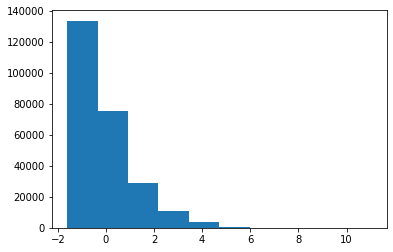

In [ ]:
# This shows distribution of words
Xp = X.flatten()
Xp = Xp[Xp > 0]
plt.hist(np.log(Xp))
np.max(Xp), len(Xp), V*V

In [ ]:
Xmax = 1000
eps=1e-3
lr = 0.01 # Consider using different learning rates and betas 
beta = 0.9
epochs = 100

np.random.seed(42)

w = 2 * (np.random.rand(2*V, emb_size) - 0.5) / (emb_size + 1)
b = 2 * (np.random.rand(2*V) - 0.5) / (emb_size + 1)
g_w_s = np.ones((2 * V, emb_size), dtype=np.float32)
g_b_s = np.ones(2 * V, dtype=np.float32)
 
indexes = []
all_idx = np.arange(V)
for i in range(V):
    mask = X[i] != 0
    if np.sum(mask) == 0: continue
    for j in all_idx[mask]:
        indexes.append((i, j))
len(indexes), indexes[0:10]

(252585,
 [(1, 2),
  (1, 4),
  (1, 5),
  (1, 6),
  (1, 7),
  (1, 8),
  (1, 9),
  (1, 10),
  (1, 11),
  (1, 12)])

In [ ]:
# Training the model 
def J():
    result = 0
    for i in range(V):
        for j in range(V):
            result += f(X[i][j]) * np.power(
                np.dot(w[i], w[j+V]) + b[i] + b[j+V] - np.log1p(X[i][j]), 2)
            
    return result

def f(x, alpha=0.75):
    if x < Xmax:
        return np.power(x / Xmax, alpha)
    else:
        return 1.0

# Gets the word index of desired word     
def W(word):
    ww = w[word_index[word]]
    return ww / np.linalg.norm(ww) # Dividing by L2 norm

all_js = []
for e in range(epochs): #tqdm(range(epochs)):
    cost = 0
    shuffle(indexes)
    for i, jj in indexes:
        j = jj + V
        weight = f(X[i][jj]) # Co-occurence matrix 
        inner = (np.dot(w[i], w[j]) + b[i] + b[j] - np.log(X[i][jj]))
        dwi = w[j] * weight * inner
        dwj = w[i] * weight * inner
        dbi = dbj = weight * inner
        cost += weight * inner ** 2
        
        # this is a variation of gradient descent
        w[i] -= lr * dwi / np.sqrt(g_w_s[i] + eps)
        w[j] -= lr * dwj / np.sqrt(g_w_s[j] + eps)
        b[i] -= lr * dbi / np.sqrt(g_b_s[i] + eps)
        b[j] -= lr * dbj / np.sqrt(g_b_s[j] + eps)

        g_w_s[i] = beta * g_w_s[i] + np.square(dwi)
        g_w_s[j] = beta * g_w_s[j] + np.square(dwj)
        g_b_s[i] = beta * g_b_s[i] + np.square(dbi)
        g_b_s[j] = beta * g_b_s[j] + np.square(dbj)
            
    all_js.append(cost)
    
    print(e, np.round(cost, 2), np.round(W('good').dot(W('bad')), 4))

0 11955.81 0.9726
1 2518.79 0.976
2 1889.88 0.9688
3 1689.09 0.9736
4 1575.24 0.9681
5 1485.62 0.9594
6 1404.03 0.9474
7 1338.15 0.9387
8 1280.12 0.9333
9 1231.59 0.9365
10 1193.03 0.9352
11 1157.64 0.9389
12 1126.08 0.9404
13 1106.2 0.9459
14 1082.73 0.9482
15 1062.85 0.9442
16 1043.76 0.9353
17 1024.79 0.9415
18 1009.74 0.9454
19 993.82 0.942
20 991.49 0.9396
21 974.27 0.9343
22 961.15 0.9343
23 955.12 0.9337
24 947.84 0.9344
25 938.2 0.9333
26 932.02 0.9282
27 925.63 0.9288
28 922.69 0.9247
29 913.7 0.9256
30 913.56 0.9231
31 902.99 0.9175
32 901.15 0.9221
33 899.34 0.9174
34 890.63 0.9182
35 888.35 0.9256
36 887.53 0.9149
37 880.8 0.9211
38 879.18 0.9139
39 876.06 0.9225
40 876.15 0.922
41 869.01 0.9229
42 871.43 0.9203
43 868.06 0.9174
44 863.64 0.9211
45 861.78 0.9148
46 862.24 0.9247
47 857.98 0.9203
48 861.51 0.916
49 855.57 0.9188
50 851.14 0.9216
51 857.46 0.9217
52 849.21 0.9187
53 852.86 0.9172
54 848.84 0.9193
55 848.06 0.9216
56 845.96 0.9204
57 844.38 0.9214
58 841.56 0.

# 3. Word2Vec

Let's first download a word2vec dictionary with a vector dimension 300 for each word from Google News.

In [14]:
import gensim.downloader as api

In [15]:
wv = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [17]:
wv

In [16]:
positive = wv["positive"]

positive.shape

(300,)

Because each word is represented as a vector in the space $\cal{R}^{300}$, we can compute similarity between words.

In [ ]:
print(wv.most_similar(positive=["king", "queen", 'royal'], topn=10))

[('monarch', 0.7630466222763062), ('prince', 0.7122635841369629), ('princess', 0.6952193379402161), ('royals', 0.691109836101532), ('princes', 0.6675853729248047), ('kings', 0.6575640439987183), ('queens', 0.6341845989227295), ('crown_prince', 0.6330041289329529), ('Queen_Consort', 0.6233130693435669), ('NYC_anglophiles_aflutter', 0.6210921406745911)]


In this case, you can simply compute the cosine distance between two words.

In [ ]:
print(wv.similarity("suv", "car" ))

0.6054363


And you can compute words that match vector operations such as $\tt{vec(king)} - \tt{vec(man)} + \tt{vec(woman)} = ?$

In [ ]:
print(wv.most_similar(positive=["king", "queen"], negative=["man"]))

[('queens', 0.595018744468689), ('monarch', 0.5815044641494751), ('kings', 0.5612993240356445), ('royal', 0.5204525589942932), ('princess', 0.5191516876220703), ('princes', 0.5086391568183899), ('NYC_anglophiles_aflutter', 0.5057314038276672), ('Queen_Consort', 0.49256715178489685), ('Queen', 0.48225677013397217), ('royals', 0.4781743586063385)]


Because every word is represented by a vector, at the end a ML model will only be able to represent vectors or differences in vectors as represented by the embedding. If the training set contains bias, the representation of the vectors will be as good as the training set.

In [ ]:
print(wv.most_similar(positive=["king", "serve"], negative=["rule"]))

[('served', 0.43512803316116333), ('serving', 0.4316672682762146), ('Serving', 0.42612528800964355), ('serves', 0.42303547263145447), ('queen', 0.3676721155643463), ('kings', 0.330525279045105), ('Sir_Francis_Walsingham', 0.32565033435821533), ('Sow_Tracey_Ullman', 0.32548266649246216), ('Centrepoint_patron', 0.3240561783313751), ('Serves', 0.3230326473712921)]


Let's see what's happening here by visualizing these 4 points.

[t-SNE] Computing 3 nearest neighbors...
[t-SNE] Indexed 4 samples in 0.000s...
[t-SNE] Computed neighbors for 4 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 4 / 4
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.593246
[t-SNE] KL divergence after 300 iterations: 0.048801
[[-201.32593   -42.881374]
 [  -5.586175  -19.825941]
 [ -92.09412  -126.23455 ]
 [-113.7346     63.29282 ]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


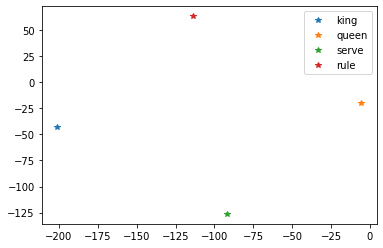

In [ ]:
king = wv['king']
queen = wv['queen']
serve = wv['serve']
rule = wv['rule']

labels = ['king', 'queen', 'serve', 'rule']
x = np.array([king, queen, serve, rule])

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(x)

print(tsne_results)

for label, coord in zip(labels, tsne_results):
    plt.plot(coord[0], coord[1], '*', label=label)
plt.legend()
plt.show()

Why is it important to remove bias from the embeddings?

Imagine in a situation where you are analyzing if you are going to give loan to a person based on the difference of two embeddings $\sum (v_1 - v_2)$, and suppose that the same difference appears in $\sum (v_3 - v_4)$.

For example, $v_1$ could be derived a sentence implying the person has good credit, and $v_2$ could be derived from a sentece where the person has no outstanding loans, whereas $v_3$ could represent a person's race, and $v_4$ could be derived from the person not paying the loan.

In our system, we will give a score based on the following result $v_1 - v_2 + v_3$ (very simple logistic classifier). The answer to the system could be a score that represents _the person will pay the loan_ or _the person will not pay the loan_. What will happen in this case?

## Answer: 
The result could be that the person is not given a loan based on the person's race. This is an instance where the model has allocation bias. Allocation bias can be seen as an economic issue, where resources are unfairly allocated to certain groups over others.<br>

This problem is due to bias present in the dataset, which stems from bias present in society. 

# 4. Doing Sentiment Analysis of IMDB Movies Using Convolutional Networks

In this part of the homework, you will implement sentiment analysis of IMDB movies using the network:

```python
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

# need to truncate sentences, do zero-padding with <PAD>.

max_sent_size = MY_MAX_SENT_SIZE
emb_size = MY_EMBEDDING_SIZE

xin = x = Input((MY_MAX_SENT_SIZE,))

model = Sequential([
    Embedding(NUM_WORDS, emb_size, input_length=max_sent_size),
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(5),
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(5),
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(5),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])
             
model.compile(loss=“binary_crossentropy”, optimizer=“adam”)

model.fit(...)
```

Compute the accuracy with the following cases:

- emb_size = 15, 25, 50, training embedding with network

- use emb_size of 300, and pre-load the embedding from 'word2vec-google-news-300'. You will need to search the internet to check how to preload the embeddings into an Embedding layer. You will need to do the tokenizer that will match the mappings from words to integers in this case, or write a conversion function from ids from imdb to word2vec embeddings from gensim.

You will probably need to run these models in a GPU or TPU. If you need assistance, please send me an email.

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from gensim.models import Word2Vec
import gensim
from keras import preprocessing
from keras.datasets import imdb
from tensorflow import keras

### Using emb_size of 15 

In [ ]:
# Creating the model
# Using emb_size of 15 
def CreateModel():
    #embedding_matrix = get_weights()

    x_i = Input(300) 
    x   = Embedding(10000, 15, 
                    input_length=maxlen,
                    trainable=False)(x_i)
                              

    x = Conv1D(128, 5, activation='relu')(x)
    x = MaxPooling1D(5)(x)
    x = Conv1D(128, 5, activation='relu')(x)
    x = MaxPooling1D(5)(x)
    x = Conv1D(128, 5, activation='relu')(x)
    x = MaxPooling1D(5)(x)
    x = Flatten()(x)
  
    x = Dense(1, activation="sigmoid")(x)

    return keras.models.Model(x_i, x)


In [ ]:
# Loading the data
num_words = 10000
maxlen = 300
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)

# Creating the model and preprocessing the data
# We pad the sentences here with zeros so it becomes a matrix. 
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)    

model = CreateModel()
model.summary()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])

# Fitting the model 
model.fit(
    x_train, y_train, epochs=20, batch_size=64,
    validation_split=0.2)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding (Embedding)       (None, 300, 15)           150000    
                                                                 
 conv1d (Conv1D)             (None, 296, 128)          9728      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 59, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 55, 128)           82048     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 11, 128)          0         
 1D)                                                         

### Using emb_size of 25

In [10]:
# Creating the model
# Using emb_size of 25 
def CreateModel():
    #embedding_matrix = get_weights()

    x_i = Input(300) 
    x   = Embedding(10000, 25, 
                    input_length=maxlen,
                    trainable=False)(x_i)
                              

    x = Conv1D(128, 5, activation='relu')(x)
    x = MaxPooling1D(5)(x)
    x = Conv1D(128, 5, activation='relu')(x)
    x = MaxPooling1D(5)(x)
    x = Conv1D(128, 5, activation='relu')(x)
    x = MaxPooling1D(5)(x)
    x = Flatten()(x)
  
    x = Dense(1, activation="sigmoid")(x)

    return keras.models.Model(x_i, x)


In [11]:
# Loading the data
num_words = 10000
maxlen = 300
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)

# Creating the model and preprocessing the data
# We pad the sentences here with zeros so it becomes a matrix. 
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)    

model = CreateModel()
model.summary()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])

# Fitting the model 
model.fit(
    x_train, y_train, epochs=20, batch_size=64,
    validation_split=0.2)

NameError: ignored

### Using emb_size of 50

In [8]:
# Creating the model
# Using emb_size of 50 
def CreateModel():
    #embedding_matrix = get_weights()

    x_i = Input(300) 
    x   = Embedding(10000, 50, 
                    input_length=maxlen,
                    trainable=False)(x_i)
                              

    x = Conv1D(128, 5, activation='relu')(x)
    x = MaxPooling1D(5)(x)
    x = Conv1D(128, 5, activation='relu')(x)
    x = MaxPooling1D(5)(x)
    x = Conv1D(128, 5, activation='relu')(x)
    x = MaxPooling1D(5)(x)
    x = Flatten()(x)
  
    x = Dense(1, activation="sigmoid")(x)

    return keras.models.Model(x_i, x)

In [9]:
# Loading the data
num_words = 10000
maxlen = 300
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)

# Creating the model and preprocessing the data
# We pad the sentences here with zeros so it becomes a matrix. 
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)    

model = CreateModel()
model.summary()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])

# Fitting the model 
model.fit(
    x_train, y_train, epochs=20, batch_size=64,
    validation_split=0.2)

NameError: ignored

### Using emb_size of 300 and word2vec-google-news-300

In [ ]:
wv_news = api.load("word2vec-google-news-300")

In [ ]:
print(type(wv_news.vectors))
wv_news.vectors.shape

In [ ]:
def get_weights():
  
    # Loading GoogleNews 
    keyed_vectors = api.load("word2vec-google-news-300")
    # vectors themselves, a 2D numpy array
    weights = keyed_vectors.vectors      

    return weights

In [ ]:
# Creating the model
# Using emb_size of 300 and word2vec-google-news-300
def CreateModel():
    embedding_matrix = get_weights()

    x_i = Input(300) 
    x   = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], 
                    weights=[embedding_matrix], 
                    input_length=maxlen,
                    trainable=False)(x_i)
                              

    x = Conv1D(128, 5, activation='relu')(x)
    x = MaxPooling1D(5)(x)
    x = Conv1D(128, 5, activation='relu')(x)
    x = MaxPooling1D(5)(x)
    x = Conv1D(128, 5, activation='relu')(x)
    x = MaxPooling1D(5)(x)
    x = Flatten()(x)
  
    x = Dense(1, activation="sigmoid")(x)

    return keras.models.Model(x_i, x)


In [ ]:
# Loading the data
num_words = 10000
maxlen = 300
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)

# Creating the model and preprocessing the data
# We pad the sentences here with zeros so it becomes a matrix. 
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)    

model = CreateModel()
model.summary()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 300, 300)          900000000 
                                                                 
 conv1d_9 (Conv1D)           (None, 296, 128)          192128    
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 59, 128)          0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 55, 128)           82048     
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 11, 128)          0         
 g1D)                                                      

In [ ]:
# Fitting the model 
model.fit(
    x_train, y_train, epochs=20, batch_size=64,
    validation_split=0.2)

Epoch 1/20
313/313 [==============================] - 3s 9ms/step - loss: 0.6824 - acc: 0.5488 - val_loss: 0.6283 - val_acc: 0.6528
Epoch 2/20
313/313 [==============================] - 3s 8ms/step - loss: 0.5713 - acc: 0.6978 - val_loss: 0.5241 - val_acc: 0.7322
Epoch 3/20
313/313 [==============================] - 3s 8ms/step - loss: 0.4162 - acc: 0.8074 - val_loss: 0.4800 - val_acc: 0.7618
Epoch 4/20
313/313 [==============================] - 3s 8ms/step - loss: 0.2463 - acc: 0.8969 - val_loss: 0.6574 - val_acc: 0.7366
Epoch 5/20
313/313 [==============================] - 3s 8ms/step - loss: 0.1139 - acc: 0.9531 - val_loss: 0.7378 - val_acc: 0.7636
Epoch 6/20
313/313 [==============================] - 3s 8ms/step - loss: 0.0738 - acc: 0.9700 - val_loss: 0.8795 - val_acc: 0.7644
Epoch 7/20
313/313 [==============================] - 3s 8ms/step - loss: 0.0506 - acc: 0.9778 - val_loss: 1.2006 - val_acc: 0.7424
Epoch 8/20
313/313 [==============================] - 3s 8ms/step - loss: 0.